### TODO

- Cluster by point at which 100 thereafter
- K-means cluster
    - How consistent are clusters across different random initialisations of cluster centers?
- Do with mean F1 across seeds
- Do individually for all seeds and see if clusters are similar
- Look at examples inside cluster
- Look dataset distribution in each cluster

In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
os.chdir('../..')

In [3]:
from src.analysis.per_example_metrics import load_adversarial_dev_as_df

In [4]:
SEEDS = [27, 28, 29]
MODELS = ['dbert', 'dbidaf', 'droberta', 'squad']

In [5]:
example_metric_df = pd.DataFrame()

for seed in SEEDS:
    for model in MODELS:
        df = pd.read_csv(f'data/processed/per_example_metrics-squadv1-adversarialall-dataset={model}-seed={seed}.csv')
        print(df.shape)
        example_metric_df = example_metric_df.append(df)
        
print(example_metric_df.shape)
example_metric_df.head()

(120000, 6)
(120000, 6)
(120000, 6)
(1268400, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(1268400, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(1268400, 6)
(4885200, 6)


,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [6]:
example_metric_df['id'].nunique()

13570

In [6]:
example_metric_df['dataset'].value_counts()

dbidaf      360000
dbert       360000
droberta    360000
Name: dataset, dtype: int64

Verify that taking mean score over examples matches metrics in JSON

In [7]:
np.random.seed(3)
example_metric_df.groupby(['checkpoint', 'dataset', 'seed']).mean().sample(n=5)

,,,exact_match,f1
checkpoint,dataset,seed,,
620,dbidaf,28,45.5,60.537007
5004,droberta,28,41.0,51.416354
332,dbidaf,28,40.7,53.994171
972,droberta,28,27.7,38.317959
1004,dbert,29,36.8,49.884105


## K-means clustering

### 3 clusters

In [8]:
example_metric_df.head()

,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [9]:
seed = 27
subset = example_metric_df.copy()[
    (example_metric_df['seed'] == seed)
]

subset.sort_values(['id', 'checkpoint'], inplace=True)

n_ts = subset['id'].nunique()
sz = 120
d = 1

X = np.zeros((n_ts, sz, d))

# Store mapping for index position to corresponding ID
idx_to_id_dict = {}

for idx, _id in enumerate(subset['id'].unique()):

    idx_to_id_dict[idx] = _id

    X[idx, :, :] = subset[subset['id'] == _id]['f1'].values.reshape(-1, 1)

In [10]:
X.shape

(3000, 120, 1)

In [12]:
km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=2, random_state=29, verbose=0, n_jobs=-1)
labels = km.fit_predict(X)

In [13]:
labels.shape

(3000,)

In [14]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])

In [15]:
id_KMlabels_df.shape

(3000, 2)

In [16]:
id_KMlabels_df.head()

,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,1
2,00245d3e103a58ff1e76c4996721a03a70412422,2
3,004241bb0375392cd909e85aeedbdf9b2f899def,2
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,0


In [18]:
subset.shape

(360000, 6)

In [17]:
subset.head()

,id,checkpoint,seed,exact_match,f1,dataset
20528,000bcf40cda48527886c945b612c0c54ed46dff8,1,27,0.0,0.0,dbidaf
20585,000bcf40cda48527886c945b612c0c54ed46dff8,2,27,0.0,0.0,dbidaf
20590,000bcf40cda48527886c945b612c0c54ed46dff8,3,27,0.0,0.0,dbidaf
20592,000bcf40cda48527886c945b612c0c54ed46dff8,4,27,0.0,0.0,dbidaf
20583,000bcf40cda48527886c945b612c0c54ed46dff8,5,27,0.0,0.0,dbidaf


In [ ]:
plot_df = subset.merge(id_KMlabels_df, on='id')
plot_df['seed'] = seed
plot_df['km_seed'] = km_seed

In [10]:
all_label_df = pd.DataFrame()

# for seed, km_seed, model in tqdm(itertools.product(SEEDS, SEEDS, MODELS), total=len(list(itertools.product(SEEDS, SEEDS, MODELS)))):
for seed, km_seed in tqdm(itertools.product(SEEDS, SEEDS), total=len(list(itertools.product(SEEDS, SEEDS)))):

    subset = example_metric_df.copy()[
#         (example_metric_df['dataset'] == model) &
        (example_metric_df['seed'] == seed)
    ]

    subset.sort_values(['id', 'checkpoint'], inplace=True)
#     assert subset.shape[0] == 120 * (1000*3 + 10570)

    n_ts = subset['id'].nunique()

#     assert n_ts == 1000*3 + 10570
    sz = 120
    d = 1

    X = np.zeros((n_ts, sz, d))

    # Store mapping for index position to corresponding ID
    idx_to_id_dict = {}

    for idx, _id in enumerate(subset['id'].unique()):

        idx_to_id_dict[idx] = _id

        X[idx, :, :] = subset[subset['id'] == _id]['f1'].values.reshape(-1, 1)


    km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=20, random_state=km_seed, verbose=0, n_jobs=-1)
    labels = km.fit_predict(X)

    id_KMlabels = []
    for idx, _id in idx_to_id_dict.items():
        id_KMlabels.append((_id, labels[idx]))

    id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])

    plot_df = subset.merge(id_KMlabels_df, on='id')
    plot_df['seed'] = seed
    plot_df['km_seed'] = km_seed
    
    print(plot_df.shape)
    print(plot_df.head())

    all_label_df = all_label_df.append(plot_df)

 11%|█         | 1/9 [04:38<37:11, 278.95s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    27          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    27          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    27          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    27          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    27          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         1       27  
1  0.0  dbidaf         1       27  
2  0.0  dbidaf         1       27  
3  0.0  dbidaf         1       27  
4  0.0  dbidaf         1       27  


 22%|██▏       | 2/9 [10:17<34:37, 296.72s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    27          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    27          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    27          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    27          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    27          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         1       28  
1  0.0  dbidaf         1       28  
2  0.0  dbidaf         1       28  
3  0.0  dbidaf         1       28  
4  0.0  dbidaf         1       28  


 33%|███▎      | 3/9 [14:42<28:43, 287.26s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    27          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    27          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    27          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    27          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    27          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         1       29  
1  0.0  dbidaf         1       29  
2  0.0  dbidaf         1       29  
3  0.0  dbidaf         1       29  
4  0.0  dbidaf         1       29  
(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    28          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    28          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3  

 44%|████▍     | 4/9 [19:43<24:17, 291.46s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    28          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    28          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    28          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    28          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    28          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         2       28  
1  0.0  dbidaf         2       28  
2  0.0  dbidaf         2       28  
3  0.0  dbidaf         2       28  
4  0.0  dbidaf         2       28  


 56%|█████▌    | 5/9 [25:46<20:51, 312.91s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    28          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    28          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    28          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    28          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    28          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         2       29  
1  0.0  dbidaf         2       29  
2  0.0  dbidaf         2       29  
3  0.0  dbidaf         2       29  
4  0.0  dbidaf         2       29  


 67%|██████▋   | 6/9 [32:49<17:18, 346.00s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    29          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    29          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    29          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    29          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    29          0.0   

     f1 dataset  KM_label  km_seed  
0  12.5  dbidaf         1       27  
1  12.5  dbidaf         1       27  
2  12.5  dbidaf         1       27  
3  12.5  dbidaf         1       27  
4  12.5  dbidaf         1       27  


 78%|███████▊  | 7/9 [36:43<10:24, 312.46s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    29          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    29          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    29          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    29          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    29          0.0   

     f1 dataset  KM_label  km_seed  
0  12.5  dbidaf         1       28  
1  12.5  dbidaf         1       28  
2  12.5  dbidaf         1       28  
3  12.5  dbidaf         1       28  
4  12.5  dbidaf         1       28  


 89%|████████▉ | 8/9 [41:42<05:08, 308.38s/it]

(360000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    29          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    29          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    29          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    29          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    29          0.0   

     f1 dataset  KM_label  km_seed  
0  12.5  dbidaf         2       29  
1  12.5  dbidaf         2       29  
2  12.5  dbidaf         2       29  
3  12.5  dbidaf         2       29  
4  12.5  dbidaf         2       29  


100%|██████████| 9/9 [46:45<00:00, 311.75s/it]


In [11]:
print(all_label_df.shape)
all_label_df.head()

(3240000, 8)


,id,checkpoint,seed,exact_match,f1,dataset,KM_label,km_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,27,0.0,0.0,dbidaf,1,27
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,27,0.0,0.0,dbidaf,1,27
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,27,0.0,0.0,dbidaf,1,27
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,27,0.0,0.0,dbidaf,1,27
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,27,0.0,0.0,dbidaf,1,27


0 (27, 27)
1 (27, 28)
2 (27, 29)
3 (28, 27)
4 (28, 28)
5 (28, 29)
6 (29, 27)
7 (29, 28)
8 (29, 29)


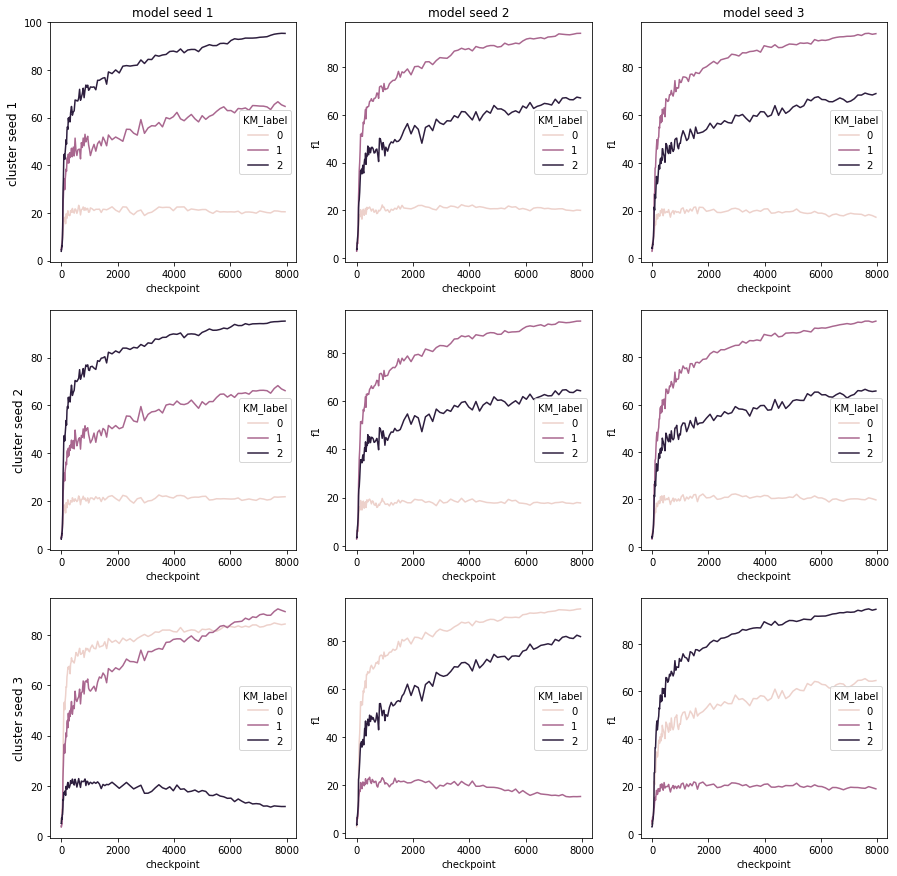

In [12]:
subplot_pos = {
    0: (0, 0),
    1: (1, 0),
    2: (2, 0),
    3: (0, 1),
    4: (1, 1),
    5: (2, 1),
    6: (0, 2),
    7: (1, 2),
    8: (2, 2),
}

fig, axs = plt.subplots(len(SEEDS), len(SEEDS), figsize=(15, 15))

for i, (seed, km_seed) in enumerate(itertools.product(SEEDS, SEEDS)):
    print(i, (seed, km_seed))
    pos_x = subplot_pos[i][0]
    pos_y = subplot_pos[i][1]
    sns.lineplot(
        data=all_label_df[
            (all_label_df['km_seed'] == km_seed) & 
            (all_label_df['seed'] == seed)
        ].groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
        x='checkpoint', 
        y='f1', 
        hue='KM_label',
        ax=axs[pos_x, pos_y]
    )
    
cols = ['model seed 1', 'model seed 2', 'model seed 3']
rows = ['cluster seed 1', 'cluster seed 2', 'cluster seed 3']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

In [14]:
all_label_df['seed'] == 28

array([27, 28, 29])

In [ ]:
# seed, km_seed
(29, 28)
(29, 29)

In [39]:
all_label_df.head()

,id,checkpoint,seed,exact_match,f1,dataset,KM_label,km_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,27,0.0,0.0,dbidaf,1,27
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,27,0.0,0.0,dbidaf,1,27
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,27,0.0,0.0,dbidaf,1,27
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,27,0.0,0.0,dbidaf,1,27
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,27,0.0,0.0,dbidaf,1,27


In [36]:
all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 28) & (all_label_df['KM_label'] == 0)]['f1'].shape

(102120,)

In [37]:
all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 28) & (all_label_df['KM_label'] == 0)]['f1']['id'].nunique()

KeyError: 'id'

In [27]:
all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 29) & (all_label_df['KM_label'] == 1)]['f1'].mean()

17.513085489476705

In [31]:
len(set(all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 28) & (all_label_df['KM_label'] == 0)]['id']).intersection(
    set(all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 29) & (all_label_df['KM_label'] == 1)]['id'])
))

827

In [40]:
all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 28) & (all_label_df['KM_label'] == 0)]['id'].nunique()

851

In [33]:
all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 28) & (all_label_df['KM_label'] == 0)]['dataset'].value_counts()

droberta    44280
dbert       34560
dbidaf      23280
Name: dataset, dtype: int64

In [35]:
all_label_df[(all_label_df['seed'] == 29) & (all_label_df['km_seed'] == 28) & (all_label_df['KM_label'] == 0)]['dataset'].value_counts()

droberta    44280
dbert       34560
dbidaf      23280
Name: dataset, dtype: int64

### 5 clusters

In [47]:
example_metric_df.head()

,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [48]:
all_label_df_5c = pd.DataFrame()

for seed, km_seed, model in tqdm(itertools.product(SEEDS, SEEDS, MODELS), total=len(list(itertools.product(SEEDS, SEEDS, MODELS)))):

    subset = example_metric_df.copy()[
        (example_metric_df['dataset'] == model) &
        (example_metric_df['seed'] == seed)
    ]

    subset.sort_values(['id', 'checkpoint'], inplace=True)

    n_ts = subset['id'].nunique()
    sz = 120
    d = 1

    X = np.zeros((n_ts, sz, d))

    # Store mapping for index position to corresponding ID
    idx_to_id_dict = {}

    for idx, _id in enumerate(subset['id'].unique()):

        idx_to_id_dict[idx] = _id

        X[idx, :, :] = subset[subset['id'] == _id]['f1'].values.reshape(-1, 1)


    km = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=20, random_state=km_seed, verbose=0, n_jobs=-1)
    labels = km.fit_predict(X)

    id_KMlabels = []
    for idx, _id in idx_to_id_dict.items():
        id_KMlabels.append((_id, labels[idx]))

    id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])

    plot_df = subset.merge(id_KMlabels_df, on='id')
    plot_df['seed'] = seed
    plot_df['km_seed'] = km_seed
    
    print(plot_df.shape)
    print(plot_df.head())

    all_label_df_5c = all_label_df_5c.append(plot_df)

  4%|▎         | 1/27 [00:40<17:21, 40.06s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    27          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    27          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    27          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    27          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    27          0.0   

          f1 dataset  KM_label  km_seed  
0  15.384615   dbert         0       27  
1  15.384615   dbert         0       27  
2  15.384615   dbert         0       27  
3  15.384615   dbert         0       27  
4  15.384615   dbert         0       27  


  7%|▋         | 2/27 [01:36<18:43, 44.95s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    27          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    27          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    27          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    27          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    27          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         4       27  
1  0.0  dbidaf         4       27  
2  0.0  dbidaf         4       27  
3  0.0  dbidaf         4       27  
4  0.0  dbidaf         4       27  


 11%|█         | 3/27 [02:53<21:51, 54.63s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    27          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    27          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    27          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    27          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    27          0.0   

          f1   dataset  KM_label  km_seed  
0  23.529412  droberta         3       27  
1  23.529412  droberta         3       27  
2  23.529412  droberta         3       27  
3  23.529412  droberta         3       27  
4  23.529412  droberta         3       27  


 15%|█▍        | 4/27 [04:25<25:14, 65.85s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    27          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    27          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    27          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    27          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    27          0.0   

          f1 dataset  KM_label  km_seed  
0  15.384615   dbert         2       28  
1  15.384615   dbert         2       28  
2  15.384615   dbert         2       28  
3  15.384615   dbert         2       28  
4  15.384615   dbert         2       28  


 19%|█▊        | 5/27 [05:08<21:37, 58.96s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    27          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    27          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    27          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    27          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    27          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         3       28  
1  0.0  dbidaf         3       28  
2  0.0  dbidaf         3       28  
3  0.0  dbidaf         3       28  
4  0.0  dbidaf         3       28  


 22%|██▏       | 6/27 [06:30<23:01, 65.78s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    27          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    27          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    27          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    27          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    27          0.0   

          f1   dataset  KM_label  km_seed  
0  23.529412  droberta         1       28  
1  23.529412  droberta         1       28  
2  23.529412  droberta         1       28  
3  23.529412  droberta         1       28  
4  23.529412  droberta         1       28  


 26%|██▌       | 7/27 [07:26<20:58, 62.91s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    27          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    27          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    27          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    27          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    27          0.0   

          f1 dataset  KM_label  km_seed  
0  15.384615   dbert         1       29  
1  15.384615   dbert         1       29  
2  15.384615   dbert         1       29  
3  15.384615   dbert         1       29  
4  15.384615   dbert         1       29  


 30%|██▉       | 8/27 [08:29<19:53, 62.81s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    27          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    27          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    27          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    27          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    27          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         3       29  
1  0.0  dbidaf         3       29  
2  0.0  dbidaf         3       29  
3  0.0  dbidaf         3       29  
4  0.0  dbidaf         3       29  


 33%|███▎      | 9/27 [09:26<18:19, 61.07s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    27          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    27          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    27          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    27          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    27          0.0   

          f1   dataset  KM_label  km_seed  
0  23.529412  droberta         1       29  
1  23.529412  droberta         1       29  
2  23.529412  droberta         1       29  
3  23.529412  droberta         1       29  
4  23.529412  droberta         1       29  


 37%|███▋      | 10/27 [10:02<15:10, 53.56s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    28          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    28          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    28          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    28          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    28          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0   dbert         4       27  
1  0.0   dbert         4       27  
2  0.0   dbert         4       27  
3  0.0   dbert         4       27  
4  0.0   dbert         4       27  


 41%|████      | 11/27 [10:54<14:12, 53.29s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    28          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    28          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    28          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    28          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    28          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         3       27  
1  0.0  dbidaf         3       27  
2  0.0  dbidaf         3       27  
3  0.0  dbidaf         3       27  
4  0.0  dbidaf         3       27  


 44%|████▍     | 12/27 [11:36<12:25, 49.70s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    28          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    28          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    28          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    28          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    28          0.0   

          f1   dataset  KM_label  km_seed  
0  54.545455  droberta         2       27  
1  54.545455  droberta         2       27  
2  54.545455  droberta         2       27  
3  54.545455  droberta         2       27  
4  54.545455  droberta         2       27  


 48%|████▊     | 13/27 [12:21<11:18, 48.46s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    28          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    28          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    28          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    28          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    28          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0   dbert         4       28  
1  0.0   dbert         4       28  
2  0.0   dbert         4       28  
3  0.0   dbert         4       28  
4  0.0   dbert         4       28  
(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    28          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    28          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3  

 52%|█████▏    | 14/27 [13:08<10:23, 47.94s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    28          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    28          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    28          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    28          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    28          0.0   

          f1   dataset  KM_label  km_seed  
0  54.545455  droberta         2       28  
1  54.545455  droberta         2       28  
2  54.545455  droberta         2       28  
3  54.545455  droberta         2       28  
4  54.545455  droberta         2       28  


 56%|█████▌    | 15/27 [14:04<10:04, 50.38s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    28          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    28          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    28          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    28          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    28          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0   dbert         1       29  
1  0.0   dbert         1       29  
2  0.0   dbert         1       29  
3  0.0   dbert         1       29  
4  0.0   dbert         1       29  


 59%|█████▉    | 16/27 [15:17<10:29, 57.27s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    28          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    28          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    28          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    28          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    28          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0  dbidaf         2       29  
1  0.0  dbidaf         2       29  
2  0.0  dbidaf         2       29  
3  0.0  dbidaf         2       29  
4  0.0  dbidaf         2       29  


 63%|██████▎   | 17/27 [16:09<09:15, 55.55s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    28          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    28          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    28          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    28          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    28          0.0   

          f1   dataset  KM_label  km_seed  
0  54.545455  droberta         1       29  
1  54.545455  droberta         1       29  
2  54.545455  droberta         1       29  
3  54.545455  droberta         1       29  
4  54.545455  droberta         1       29  


 67%|██████▋   | 18/27 [16:55<07:55, 52.79s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    29          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    29          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    29          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    29          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    29          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0   dbert         0       27  
1  0.0   dbert         0       27  
2  0.0   dbert         0       27  
3  0.0   dbert         0       27  
4  0.0   dbert         0       27  


 70%|███████   | 19/27 [18:10<07:55, 59.40s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    29          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    29          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    29          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    29          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    29          0.0   

     f1 dataset  KM_label  km_seed  
0  12.5  dbidaf         0       27  
1  12.5  dbidaf         0       27  
2  12.5  dbidaf         0       27  
3  12.5  dbidaf         0       27  
4  12.5  dbidaf         0       27  


 74%|███████▍  | 20/27 [18:56<06:27, 55.34s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    29          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    29          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    29          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    29          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    29          0.0   

          f1   dataset  KM_label  km_seed  
0  11.111111  droberta         2       27  
1  11.111111  droberta         2       27  
2  11.111111  droberta         2       27  
3  11.111111  droberta         2       27  
4  13.333333  droberta         2       27  


 78%|███████▊  | 21/27 [19:44<05:18, 53.14s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    29          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    29          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    29          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    29          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    29          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0   dbert         2       28  
1  0.0   dbert         2       28  
2  0.0   dbert         2       28  
3  0.0   dbert         2       28  
4  0.0   dbert         2       28  


 81%|████████▏ | 22/27 [21:02<05:03, 60.75s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    29          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    29          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    29          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    29          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    29          0.0   

     f1 dataset  KM_label  km_seed  
0  12.5  dbidaf         4       28  
1  12.5  dbidaf         4       28  
2  12.5  dbidaf         4       28  
3  12.5  dbidaf         4       28  
4  12.5  dbidaf         4       28  


 85%|████████▌ | 23/27 [22:10<04:11, 62.88s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    29          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    29          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    29          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    29          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    29          0.0   

          f1   dataset  KM_label  km_seed  
0  11.111111  droberta         3       28  
1  11.111111  droberta         3       28  
2  11.111111  droberta         3       28  
3  11.111111  droberta         3       28  
4  13.333333  droberta         3       28  


 89%|████████▉ | 24/27 [23:23<03:17, 65.77s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           1    29          0.0   
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           2    29          0.0   
2  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           3    29          0.0   
3  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           4    29          0.0   
4  001a30863d32440f80d5f4f65e7bb3ee0698f0a0           5    29          0.0   

    f1 dataset  KM_label  km_seed  
0  0.0   dbert         2       29  
1  0.0   dbert         2       29  
2  0.0   dbert         2       29  
3  0.0   dbert         2       29  
4  0.0   dbert         2       29  


 93%|█████████▎| 25/27 [24:18<02:04, 62.50s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  000bcf40cda48527886c945b612c0c54ed46dff8           1    29          0.0   
1  000bcf40cda48527886c945b612c0c54ed46dff8           2    29          0.0   
2  000bcf40cda48527886c945b612c0c54ed46dff8           3    29          0.0   
3  000bcf40cda48527886c945b612c0c54ed46dff8           4    29          0.0   
4  000bcf40cda48527886c945b612c0c54ed46dff8           5    29          0.0   

     f1 dataset  KM_label  km_seed  
0  12.5  dbidaf         0       29  
1  12.5  dbidaf         0       29  
2  12.5  dbidaf         0       29  
3  12.5  dbidaf         0       29  
4  12.5  dbidaf         0       29  


 96%|█████████▋| 26/27 [24:58<00:55, 55.81s/it]

(120000, 8)
                                         id  checkpoint  seed  exact_match  \
0  00245d3e103a58ff1e76c4996721a03a70412422           1    29          0.0   
1  00245d3e103a58ff1e76c4996721a03a70412422           2    29          0.0   
2  00245d3e103a58ff1e76c4996721a03a70412422           3    29          0.0   
3  00245d3e103a58ff1e76c4996721a03a70412422           4    29          0.0   
4  00245d3e103a58ff1e76c4996721a03a70412422           5    29          0.0   

          f1   dataset  KM_label  km_seed  
0  11.111111  droberta         2       29  
1  11.111111  droberta         2       29  
2  11.111111  droberta         2       29  
3  11.111111  droberta         2       29  
4  13.333333  droberta         2       29  


100%|██████████| 27/27 [25:54<00:00, 57.57s/it]


In [49]:
print(all_label_df_5c.shape)
all_label_df_5c.head()

(3240000, 8)


,id,checkpoint,seed,exact_match,f1,dataset,KM_label,km_seed
0,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,1,27,0.0,15.384615,dbert,0,27
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,2,27,0.0,15.384615,dbert,0,27
2,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,3,27,0.0,15.384615,dbert,0,27
3,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,4,27,0.0,15.384615,dbert,0,27
4,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,5,27,0.0,15.384615,dbert,0,27


0 (27, 27)
1 (27, 28)
2 (27, 29)
3 (28, 27)
4 (28, 28)
5 (28, 29)
6 (29, 27)
7 (29, 28)
8 (29, 29)


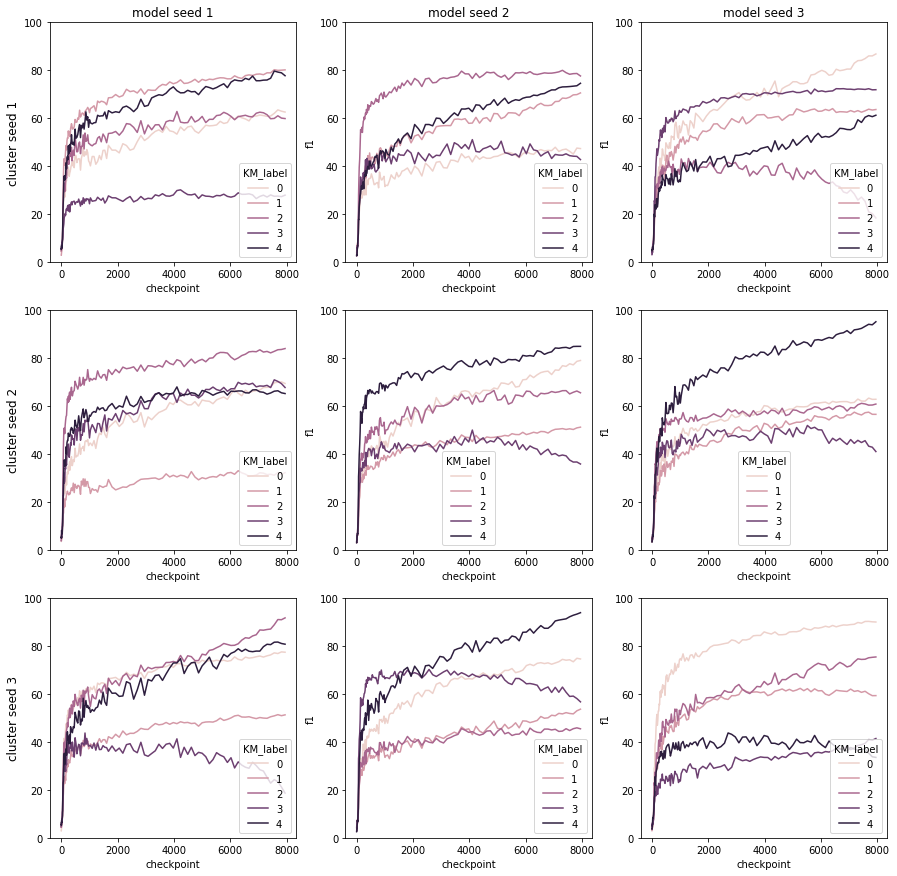

In [53]:
subplot_pos = {
    0: (0, 0),
    1: (1, 0),
    2: (2, 0),
    3: (0, 1),
    4: (1, 1),
    5: (2, 1),
    6: (0, 2),
    7: (1, 2),
    8: (2, 2),
}

fig, axs = plt.subplots(len(SEEDS), len(SEEDS), figsize=(15, 15))

for i, (seed, km_seed) in enumerate(itertools.product(SEEDS, SEEDS)):
    print(i, (seed, km_seed))
    pos_x = subplot_pos[i][0]
    pos_y = subplot_pos[i][1]
    sns.lineplot(
        data=all_label_df_5c[
            (all_label_df_5c['km_seed'] == km_seed) & 
            (all_label_df_5c['seed'] == seed)
        ].groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
        x='checkpoint', 
        y='f1', 
        hue='KM_label',
        ax=axs[pos_x, pos_y]
    )
    axs[pos_x, pos_y].set_ylim(0, 100, 10)
    
cols = ['model seed 1', 'model seed 2', 'model seed 3']
rows = ['cluster seed 1', 'cluster seed 2', 'cluster seed 3']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

Take mean F1 for each example across seeds

In [61]:
example_metric_df.head()

,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [62]:
example_metric_mean_df = example_metric_df.groupby(['id', 'checkpoint', 'dataset']).mean().reset_index()
example_metric_mean_df.drop('seed', axis=1, inplace=True)
print(example_metric_mean_df.shape)
example_metric_mean_df.head()

(360000, 5)


,id,checkpoint,dataset,exact_match,f1
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667


In [63]:
example_metric_mean_df['id'].nunique()

3000

In [64]:
example_metric_mean_df.groupby('dataset').nunique()

,id,checkpoint,exact_match,f1
dataset,,,,
dbert,1000,120,4,4333
dbidaf,1000,120,4,3866
droberta,1000,120,4,4412


In [65]:
example_metric_mean_df.sort_values(['id', 'checkpoint'], inplace=True)

In [13]:
# example_metric_mean_df['f1_diff'] = example_metric_mean_df.groupby('id')['f1'].diff()

In [14]:
# example_metric_mean_df.dropna(axis=0, inplace=True)

Input, `X`, for `TimeSeriesKMeans` needs to be of dim (`n_ts`, `sz`, `d`)

`n_ts` - Number of time series.

`sz` - Length of time series (number of time instants).

`d` - Dimensionality of time series.

Construct X

In [66]:
example_metric_mean_df.shape

(360000, 5)

In [67]:
example_metric_mean_df.head()

,id,checkpoint,dataset,exact_match,f1
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667


In [68]:
n_ts = example_metric_mean_df['id'].nunique()
sz = 120
# sz = 119
d = 1

X = np.zeros((n_ts, sz, d))

In [69]:
example_metric_mean_df.sort_values(['id', 'checkpoint'], inplace=True)

# Store mapping for index position to corresponding ID
idx_to_id_dict = {}

for idx, _id in tqdm(
    enumerate(example_metric_mean_df['id'].unique()),
    total=example_metric_mean_df['id'].nunique()
):
    
    idx_to_id_dict[idx] = _id
    
    X[idx, :, :] = example_metric_mean_df[example_metric_mean_df['id'] == _id]['f1'].values.reshape(-1, 1)
#     X[idx, :, :] = example_metric_mean_df[example_metric_mean_df['id'] == _id]['f1_diff'].values.reshape(-1, 1)

100%|██████████| 3000/3000 [00:51<00:00, 58.72it/s]


Check example

In [70]:
np.random.seed(3)

test_id = example_metric_mean_df['id'].sample(n=1).item()

reverse_dict = {v: k for k, v in idx_to_id_dict.items()}

np.testing.assert_array_equal(
    X[reverse_dict[test_id], :, :], 
    example_metric_mean_df[example_metric_mean_df['id'] == test_id]['f1'].values.reshape(-1, 1)
)

### 3 clusters

#### Seed 27

In [93]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=20, random_state=27, verbose=0, n_jobs=-1)

In [94]:
%%time
labels = km.fit_predict(X)

CPU times: user 14min 24s, sys: 2min 19s, total: 16min 44s
Wall time: 6min 7s


In [95]:
km.n_iter_

20

In [96]:
labels

array([1, 4, 3, ..., 4, 4, 0])

In [97]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

In [98]:
id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])
print(id_KMlabels_df.shape)
id_KMlabels_df.head()

(3000, 2)


,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,4
2,00245d3e103a58ff1e76c4996721a03a70412422,3
3,004241bb0375392cd909e85aeedbdf9b2f899def,0
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2


In [99]:
id_KMlabels_df['KM_label'].value_counts()

2    1019
4     661
1     594
0     384
3     342
Name: KM_label, dtype: int64

In [100]:
plot_df = example_metric_mean_df.merge(id_KMlabels_df, on='id')
print(plot_df.shape)
plot_df.head()

(360000, 6)


,id,checkpoint,dataset,exact_match,f1,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,1
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,1
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,1
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,1
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,1


In [101]:
plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index().head()

,checkpoint,KM_label,exact_match,f1
0,1,0,0.086806,4.863402
1,1,1,0.112233,3.413011
2,1,2,0.032712,3.299434
3,1,3,0.000000,4.163065
4,1,4,0.151286,4.617735


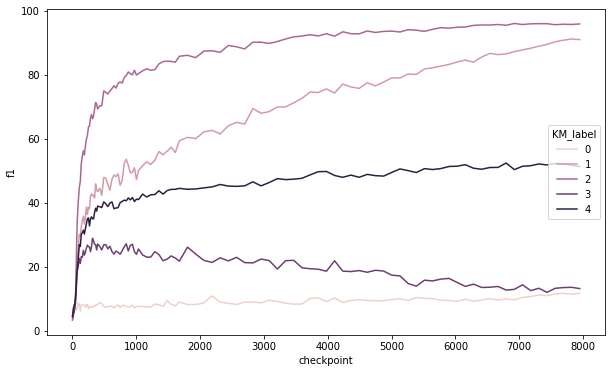

In [102]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
    x='checkpoint', 
    y='f1', 
    hue='KM_label'
)
plt.show()

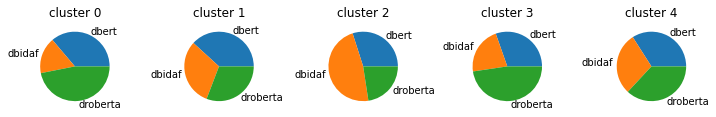

In [103]:
fig, axs = plt.subplots(1, plot_df['KM_label'].nunique(), figsize=(10, 5*plot_df['KM_label'].nunique()))

for i, label in enumerate(np.sort(plot_df['KM_label'].unique())):
    axs[i].pie(
        x=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['id'],
        labels=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['dataset']
    )
    axs[i].set_title(f'cluster {label}')
plt.tight_layout()
plt.show()

#### Seed 28

In [104]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=20, random_state=28, verbose=0, n_jobs=-1)

In [105]:
%%time
labels = km.fit_predict(X)

CPU times: user 13min 9s, sys: 2min 4s, total: 15min 14s
Wall time: 5min 16s


In [106]:
km.n_iter_

19

In [107]:
labels

array([2, 4, 0, ..., 4, 4, 0])

In [108]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

In [109]:
id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])
print(id_KMlabels_df.shape)
id_KMlabels_df.head()

(3000, 2)


,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,2
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,4
2,00245d3e103a58ff1e76c4996721a03a70412422,0
3,004241bb0375392cd909e85aeedbdf9b2f899def,0
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,1


In [110]:
id_KMlabels_df['KM_label'].value_counts()

1    1041
4     562
0     524
2     437
3     436
Name: KM_label, dtype: int64

In [111]:
plot_df = example_metric_mean_df.merge(id_KMlabels_df, on='id')
print(plot_df.shape)
plot_df.head()

(360000, 6)


,id,checkpoint,dataset,exact_match,f1,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,2
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,2
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,2
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,2
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,2


In [112]:
plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index().head()

,checkpoint,KM_label,exact_match,f1
0,1,0,0.063613,4.741827
1,1,1,0.064041,3.125783
2,1,2,0.152555,4.753750
3,1,3,0.076453,4.343666
4,1,4,0.059312,3.600009


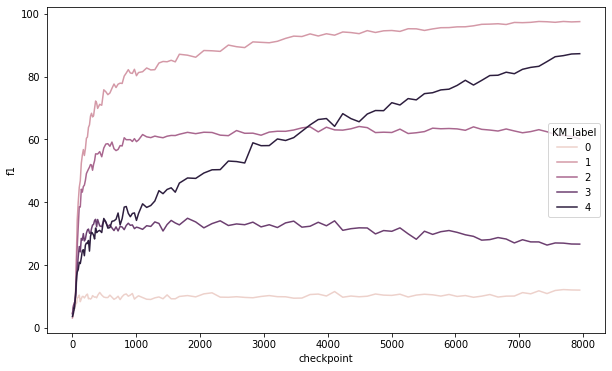

In [113]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
    x='checkpoint', 
    y='f1', 
    hue='KM_label'
)
plt.show()

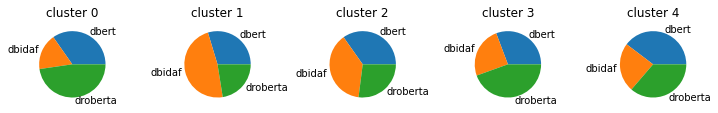

In [114]:
fig, axs = plt.subplots(1, plot_df['KM_label'].nunique(), figsize=(10, 5*plot_df['KM_label'].nunique()))

for i, label in enumerate(np.sort(plot_df['KM_label'].unique())):
    axs[i].pie(
        x=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['id'],
        labels=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['dataset']
    )
    axs[i].set_title(f'cluster {label}')
plt.tight_layout()
plt.show()

What are the questions in AdversarialQA which belong to cluster 0?

### 5 clusters

In [36]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=20, random_state=0, verbose=1, n_jobs=-1)

In [37]:
%%time
labels = km.fit_predict(X)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

10328.121 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7569.777 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7518.512 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7509.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7504.193 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7489.425 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7478.963 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7463.594 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7455.223 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7449.974 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7444.971 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7411.263 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7402.568 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7392.925 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7389.227 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7387.333 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7386.813 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7386.586 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7376.346 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

7375.677 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

CPU times: user 38min 37s, sys: 6min 19s, total: 44min 57s
Wall time: 26min 31s


[Parallel(n_jobs=-1)]: Done 67850 out of 67850 | elapsed:    7.9s finished


In [38]:
km.n_iter_

20

In [39]:
labels

array([3, 3, 1, ..., 3, 3, 1])

In [40]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

In [41]:
id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])
print(id_KMlabels_df.shape)
id_KMlabels_df.head()

(13570, 2)


,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,3
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,3
2,00245d3e103a58ff1e76c4996721a03a70412422,1
3,004241bb0375392cd909e85aeedbdf9b2f899def,1
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2


In [42]:
id_KMlabels_df['KM_label'].value_counts()

0    7137
2    2233
4    1948
3    1225
1    1027
Name: KM_label, dtype: int64

In [43]:
plot_df = example_metric_mean_df.merge(id_KMlabels_df, on='id')
print(plot_df.shape)
plot_df.head()

(1628400, 6)


,id,checkpoint,dataset,exact_match,f1,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,3
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,3
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,3
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,3
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,3


In [44]:
plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index().head()

,checkpoint,KM_label,exact_match,f1
0,1,0,0.060716,3.837914
1,1,1,0.064914,4.926957
2,1,2,0.253769,8.880585
3,1,3,0.136054,5.638954
4,1,4,0.051335,3.659528


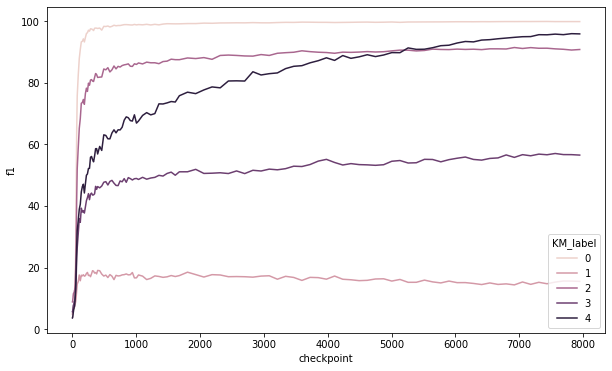

In [45]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
    x='checkpoint', 
    y='f1', 
    hue='KM_label'
)
plt.show()

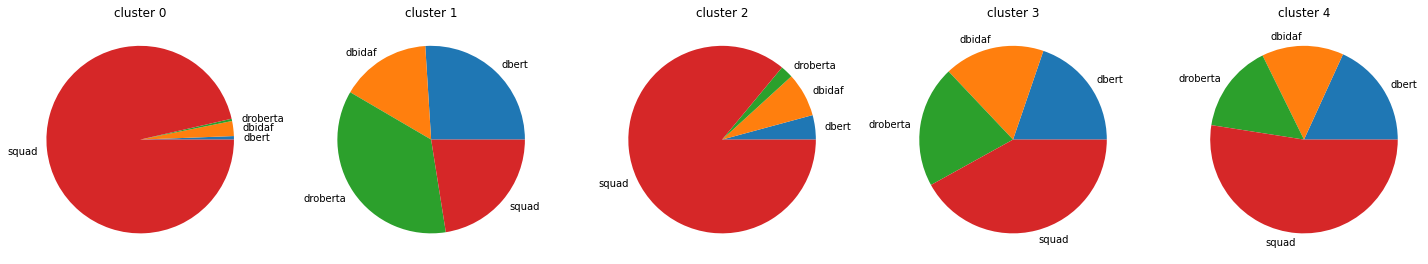

In [46]:
fig, axs = plt.subplots(1, plot_df['KM_label'].nunique(), figsize=(20, 5*plot_df['KM_label'].nunique()))

for i, label in enumerate(np.sort(plot_df['KM_label'].unique())):
    axs[i].pie(
        x=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['id'],
        labels=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['dataset']
    )
    axs[i].set_title(f'cluster {label}')
plt.tight_layout()
plt.show()

### 10 clusters

In [85]:
km = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=300, random_state=0, verbose=0, n_jobs=-1)

In [86]:
%%time
labels = km.fit_predict(X)

CPU times: user 16min 42s, sys: 2min 49s, total: 19min 32s
Wall time: 6min 15s


In [87]:
km.n_iter_

20

In [88]:
labels

array([0, 7, 1, ..., 4, 3, 9])

In [89]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

In [90]:
id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])
print(id_KMlabels_df.shape)
id_KMlabels_df.head()

(3000, 2)


,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,0
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,7
2,00245d3e103a58ff1e76c4996721a03a70412422,1
3,004241bb0375392cd909e85aeedbdf9b2f899def,9
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2


In [91]:
id_KMlabels_df['KM_label'].value_counts()

2    604
8    404
4    399
5    326
1    301
9    296
7    238
6    182
0    134
3    116
Name: KM_label, dtype: int64

In [92]:
plot_df = example_metric_mean_df.merge(id_KMlabels_df, on='id')
print(plot_df.shape)
plot_df.head()

(360000, 6)


,id,checkpoint,dataset,exact_match,f1,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,0
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,0
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,0
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,0
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,0


In [93]:
plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index().head()

,checkpoint,KM_label,exact_match,f1
0,1,0,0.497512,3.949970
1,1,1,0.000000,4.291581
2,1,2,0.055188,3.232755
3,1,3,0.000000,4.297672
4,1,4,0.167084,5.121328


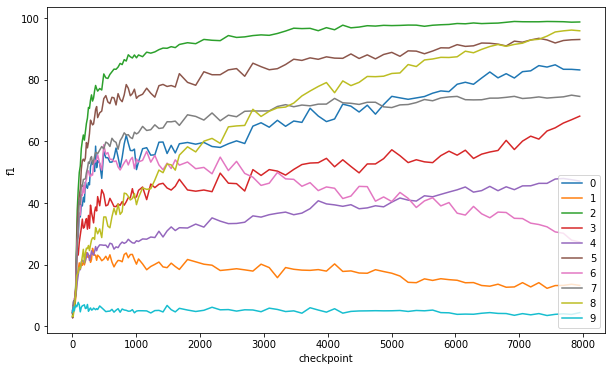

In [106]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
    x='checkpoint', 
    y='f1', 
    hue='KM_label',
    legend='full',
    palette='tab10'
)
plt.legend()
plt.show()

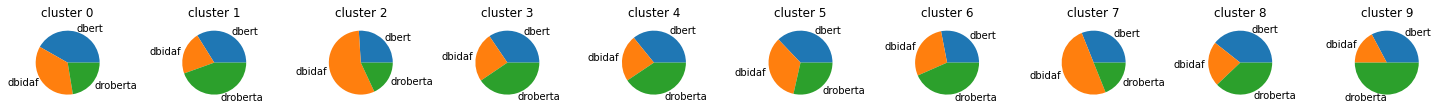

In [104]:
fig, axs = plt.subplots(1, plot_df['KM_label'].nunique(), figsize=(20, 5*plot_df['KM_label'].nunique()))

for i, label in enumerate(np.sort(plot_df['KM_label'].unique())):
    axs[i].pie(
        x=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['id'],
        labels=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['dataset']
    )
    axs[i].set_title(f'cluster {label}')
plt.tight_layout()
plt.show()

100%|██████████| 182/182 [00:01<00:00, 100.22it/s]


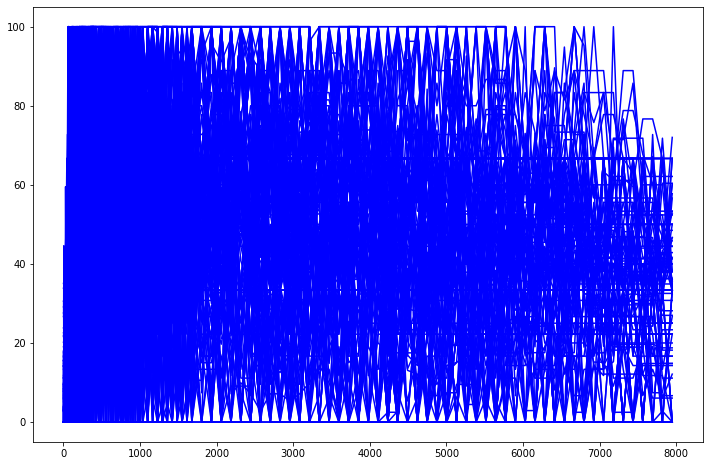

In [110]:
plt.figure(figsize=(12, 8))
for _id in tqdm(plot_df[plot_df['KM_label'] == 6]['id'].unique()):
    plt.plot(
        plot_df[plot_df['KM_label'] == 6][plot_df[plot_df['KM_label'] == 6]['id'] == _id]['checkpoint'],
        plot_df[plot_df['KM_label'] == 6][plot_df[plot_df['KM_label'] == 6]['id'] == _id]['f1'],
        color='blue'
    )
plt.show()

In [115]:
adversarial_qa_labels = pd.DataFrame()

for model in MODELS:
    df = load_adversarial_dev_as_df(model)
    adversarial_qa_labels = adversarial_qa_labels.append(df)

2021-08-05 01:15:23,897 - Loading dbert dev data as DataFrame
2021-08-05 01:15:24,363 - Reusing dataset adversarial_qa (/Users/stevengeorge/.cache/huggingface/datasets/adversarial_qa/dbert/1.0.0/2f8c1f6e146e203b3fde4b73427f19abf4ab44f315df4ccd7613f03caf3c2971)
2021-08-05 01:15:24,462 - (1000, 6)
2021-08-05 01:15:24,462 -                                              answers  \
0  {'answer_start': [101], 'text': ['average prof...   
1  {'answer_start': [185], 'text': ['anxiety, dep...   
2    {'answer_start': [123], 'text': ['2012 study']}   
3  {'answer_start': [121], 'text': ['A 2012 study']}   
4              {'answer_start': [3], 'text': ['US']}   

                                             context  \
0  A 2000 study found that 42% of UK teachers exp...   
1  A 2000 study found that 42% of UK teachers exp...   
2  A 2000 study found that 42% of UK teachers exp...   
3  A 2000 study found that 42% of UK teachers exp...   
4  30 US states have banned corporal punishment, ...   

   

In [116]:
adversarial_qa_labels.shape

(3000, 6)

In [117]:
adversarial_qa_labels['id'].nunique()

3000

In [122]:
plot_df_with_labels = plot_df.merge(adversarial_qa_labels, on='id')
plot_df_with_labels.head()

,id,checkpoint,dataset,exact_match,f1,KM_label,answers,context,metadata,question,title
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther


In [128]:
np.random.seed(3)

for _, row in plot_df_with_labels[plot_df_with_labels['KM_label'] == 6].sample(n=5).iterrows():
    print(row['id'])
    print(row['context'])
    print(row['question'])
    print('\n')

9fb0e5e03a5c05b4e7d1c6b97ac34abb435b2d90
In late November 2015, reports surfaced stating that "multiple acts" would perform during the halftime show. On December 3, the league confirmed that the show would be headlined by the British rock group Coldplay. On January 7, 2016, Pepsi confirmed to the Associated Press that Beyoncé, who headlined the Super Bowl XLVII halftime show and collaborated with Coldplay on the single "Hymn for the Weekend", would be making an appearance. Bruno Mars, who headlined the Super Bowl XLVIII halftime show, and Mark Ronson also performed.
Who headlined Super Bowl 48?


71fb2a94a984342827805dbb12ea03f9d4acf7c9
Luther spoke out against the Jews in Saxony, Brandenburg, and Silesia. Josel of Rosheim, the Jewish spokesman who tried to help the Jews of Saxony in 1537, later blamed their plight on "that priest whose name was Martin Luther—may his body and soul be bound up in hell!—who wrote and issued many heretical books in which he said that whoever would help th

## Other stuff

In [6]:
example_metric_mean_df = example_metric_df.groupby(['id', 'checkpoint', 'dataset']).mean().reset_index()
print(example_metric_mean_df.shape)
example_metric_mean_df.head()

(360000, 6)


,id,checkpoint,dataset,seed,exact_match,f1
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,28,0.0,4.166667
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,28,0.0,4.166667
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,28,0.0,4.166667
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,28,0.0,4.166667
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,28,0.0,4.166667


In [7]:
example_metric_mean_df['id'].nunique()

3000

In [8]:
example_metric_mean_df.groupby('dataset').nunique()

,id,checkpoint,seed,exact_match,f1
dataset,,,,,
dbert,1000,120,1,4,4333
dbidaf,1000,120,1,4,3866
droberta,1000,120,1,4,4412


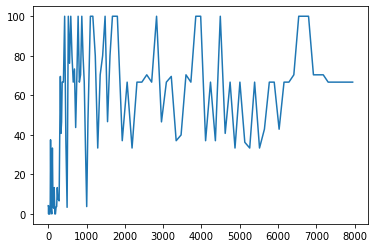

In [9]:
plt.plot(
example_metric_mean_df[example_metric_mean_df['id'] == '000bcf40cda48527886c945b612c0c54ed46dff8']['checkpoint'],
example_metric_mean_df[example_metric_mean_df['id'] == '000bcf40cda48527886c945b612c0c54ed46dff8']['f1']
)

In [10]:
example_metric_mean_df.shape

(360000, 6)

In [11]:
example_metric_mean_df[example_metric_mean_df['f1'] == 100]['checkpoint'].describe()

count    72480.000000
mean      3721.754636
std       2519.294627
min         52.000000
25%       1164.000000
50%       3724.000000
75%       6028.000000
max       7948.000000
Name: checkpoint, dtype: float64

In [12]:
example_metric_mean_df[example_metric_mean_df['id'] == '000bcf40cda48527886c945b612c0c54ed46dff8']['f1'].diff()

0      NaN
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
Name: f1, Length: 120, dtype: float64

In [13]:
example_metric_mean_df.groupby('id').mean()['f1'].max()

87.77777777777779

In [14]:
finish_on_100 = example_metric_mean_df[(example_metric_mean_df['checkpoint'] == 7948) & (example_metric_mean_df['f1'] == 100)][['id']].reset_index(drop=True)
finish_on_100['finish_on_100'] = 1
print(finish_on_100.shape)
finish_on_100.head()

(1207, 2)


,id,finish_on_100
0,0054d06bf3be61edaa33f71cf897f98a37e73ea8,1
1,00b4f6a5f86df49f018c808959a6c010ef344ec3,1
2,014b21e6cca775f8d8d46f27b64a7d9e4f43dd7c,1
3,014b4f904d0dc326b0fe559497047324e21884a6,1
4,015917de773ce636b02c024fbc3f2a17b471f010,1


In [15]:
example_metric_mean_df = example_metric_mean_df.merge(finish_on_100, how='left', on='id')
example_metric_mean_df['finish_on_100'].fillna(0, inplace=True)
print(example_metric_mean_df.shape)
example_metric_mean_df.head()

(360000, 7)


,id,checkpoint,dataset,seed,exact_match,f1,finish_on_100
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,28,0.0,4.166667,0.0
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,28,0.0,4.166667,0.0
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,28,0.0,4.166667,0.0
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,28,0.0,4.166667,0.0
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,28,0.0,4.166667,0.0


In [16]:
finish_on_100 = example_metric_mean_df[example_metric_mean_df['finish_on_100'] == 1]
print(finish_on_100.shape)
finish_on_100.head()

(144840, 7)


,id,checkpoint,dataset,seed,exact_match,f1,finish_on_100
480,0054d06bf3be61edaa33f71cf897f98a37e73ea8,1,dbidaf,28,0.0,13.333333,1.0
481,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2,dbidaf,28,0.0,13.333333,1.0
482,0054d06bf3be61edaa33f71cf897f98a37e73ea8,3,dbidaf,28,0.0,13.333333,1.0
483,0054d06bf3be61edaa33f71cf897f98a37e73ea8,4,dbidaf,28,0.0,13.333333,1.0
484,0054d06bf3be61edaa33f71cf897f98a37e73ea8,5,dbidaf,28,0.0,13.333333,1.0


100%|██████████| 1207/1207 [00:18<00:00, 64.53it/s]


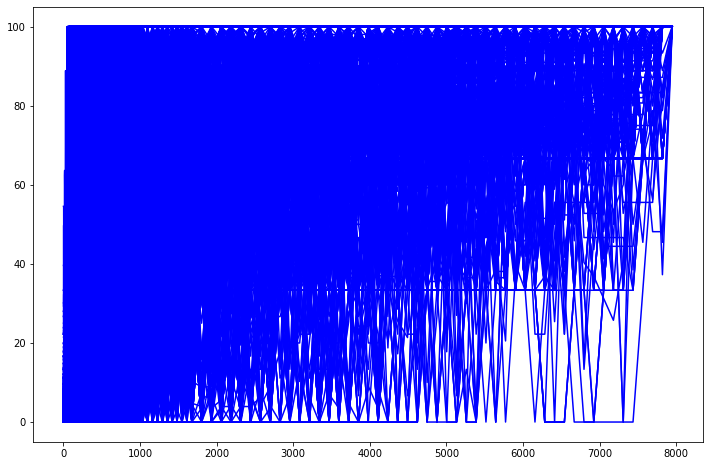

In [17]:
plt.figure(figsize=(12, 8))
for _id in tqdm(finish_on_100['id'].unique()):
    plt.plot(
        finish_on_100[finish_on_100['id'] == _id]['checkpoint'],
        finish_on_100[finish_on_100['id'] == _id]['f1'],
        color='blue'
    )
plt.show()

In [18]:
finish_on_100.drop('seed', inplace=True, axis=1)
finish_on_100.sort_values(['id', 'checkpoint'], ascending=False, inplace=True)
finish_on_100.head()

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,checkpoint,dataset,exact_match,f1,finish_on_100
359279,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7948,droberta,100.000000,100.000000,1.0
359278,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7820,droberta,66.666667,71.794872,1.0
359277,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7692,droberta,100.000000,100.000000,1.0
359276,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7564,droberta,66.666667,71.794872,1.0
359275,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7436,droberta,33.333333,38.461538,1.0


In [19]:
finish_on_100['diff'] = finish_on_100.groupby(['id'])['f1'].diff()

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
finish_on_100['diff'].fillna(0, inplace=True)

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/pandas/core/series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [21]:
chkpt_100_thereafter = finish_on_100[finish_on_100['diff'] != 0].groupby('id')['checkpoint'].max().reset_index()
print(chkpt_100_thereafter.shape)
chkpt_100_thereafter.head()

(1207, 2)


,id,checkpoint
0,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2188
1,00b4f6a5f86df49f018c808959a6c010ef344ec3,6284
2,014b21e6cca775f8d8d46f27b64a7d9e4f43dd7c,3084
3,014b4f904d0dc326b0fe559497047324e21884a6,5132
4,015917de773ce636b02c024fbc3f2a17b471f010,396


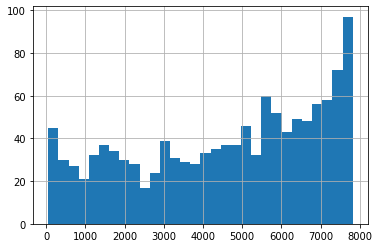

In [22]:
chkpt_100_thereafter['checkpoint'].hist(bins=30)
plt.show()

In [23]:
chkpt_100_thereafter.describe()

,checkpoint
count,1207.000000
mean,4562.223695
std,2338.467682
min,52.000000
25%,2700.000000
50%,5004.000000
75%,6604.000000
max,7820.000000


In [24]:
chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values

array(['069b1721a0d8face50835e9c2d387d669f855d34',
       '17408941318fb9c79bcfe8ce2c14cd0abdca46d4',
       '3904cd560e47bfef8a77eedea659e773d9899761',
       '425c26a9f94ac7f2c09a173a8101b63a2fbff509',
       '43b0aedaf9efe9f7c2c23aa998c22aa9872f5a2c',
       '575e873aafa3801bb3f700df33b36ab1b2fcac31',
       '5980585b3df621a1c705bfc2cac4d4c35e7b1c8f',
       '7a91e42d951791eb45d2f580bdfcf5b5afe888e3',
       '8005c14e861b8a6e81ec9e235e580117a54b39fd',
       '97e723e3d467c4adf25f5a2e1ed2d388063c7349',
       '998a85bf35193719ce4c63c57eda0dc001818b4b',
       '9c14d41d3fee9df93dc80aab1941977ee6e3c2a4',
       '9d4b0f20a55f80bf9bc2a35618a929789a2e58c4',
       'af9e58180ad94b3fc5682657366a312c8ff8e87b',
       'b407409dd3fea2022ba487aa9f451a9577386cd5',
       'be11dc4533d50d5ee7e30995ef8c28a064c9a8fc',
       'c4c25f3cba310af0d3ffa5cabf10f012b1e1a3e3',
       'dc15a9693507511987169dcf0b8d1aaed73fc92d',
       'de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f'], dtype=object)

In [25]:
finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]

,id,checkpoint,dataset,exact_match,f1,finish_on_100,diff
312359,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7948,droberta,100.0,100.00000,1.0,0.000000
312358,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7820,droberta,100.0,100.00000,1.0,0.000000
312357,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7692,droberta,100.0,100.00000,1.0,0.000000
312356,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7564,droberta,100.0,100.00000,1.0,0.000000
312355,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7436,droberta,100.0,100.00000,1.0,0.000000
...,...,...,...,...,...,...,...
10804,069b1721a0d8face50835e9c2d387d669f855d34,5,dbidaf,0.0,9.76431,1.0,3.703704
10803,069b1721a0d8face50835e9c2d387d669f855d34,4,dbidaf,0.0,9.76431,1.0,0.000000
10802,069b1721a0d8face50835e9c2d387d669f855d34,3,dbidaf,0.0,9.76431,1.0,0.000000
10801,069b1721a0d8face50835e9c2d387d669f855d34,2,dbidaf,0.0,9.76431,1.0,0.000000


100%|██████████| 19/19 [00:00<00:00, 38.18it/s]


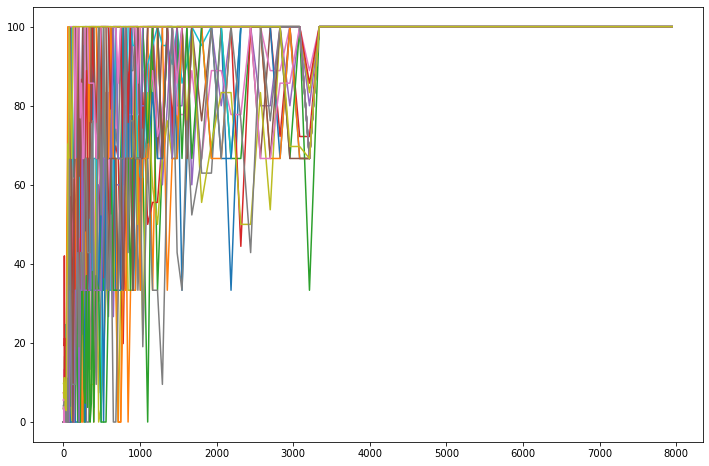

In [26]:
plt.figure(figsize=(12, 8))
for _id in tqdm(finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]['id'].unique()):
    plt.plot(
        finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)][finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]['id'] == _id]['checkpoint'],
        finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)][finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]['id'] == _id]['f1'],
    )
plt.show()

<AxesSubplot:xlabel='checkpoint'>

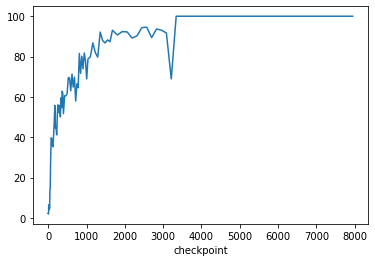

In [27]:
finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)].groupby('checkpoint').mean()['f1'].plot()

In [ ]:
plot_df.groupby()